In [1]:
import torch
from torch import nn, utils
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

## Data prepare

In [3]:
# urllib.request.urlretrieve('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',\
#                            filename='./imdb-dataset.csv')
dataset_path = './imdb-dataset.csv'
data = pd.read_csv(dataset_path)
print(data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [4]:
print('len of data : ', len(data))

len of data :  50000


## preprocessing

In [5]:
data['review'].nunique(), data['sentiment'].nunique()

(49582, 2)

In [6]:
data.drop_duplicates(subset=['review'], inplace=True) # remove duplicates in document column
print('total num of data :',len(data))

total num of data : 49582


  sentiment  count
0  negative  24698
1  positive  24884


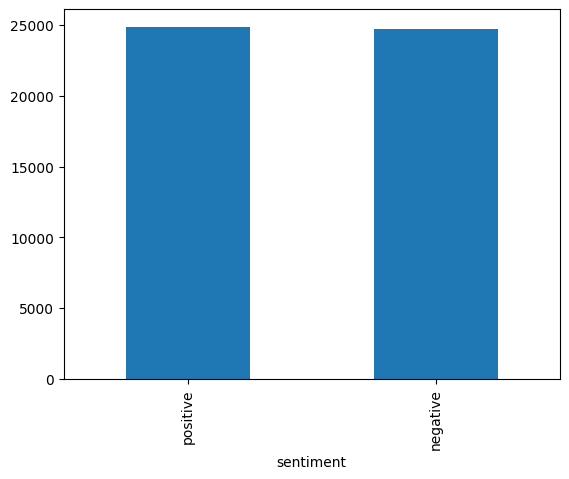

In [7]:
data['sentiment'].value_counts().plot(kind = 'bar')
print(data.groupby('sentiment').size().reset_index(name = 'count'))

In [8]:
if data.isnull().values.any():
    data.loc[data.document.isnull()]
    data = data.dropna(how = 'any') # remove Null columns

print(data.isnull().sum())
print('total num of data :',len(data))

review       0
sentiment    0
dtype: int64
total num of data : 49582


In [9]:
# data['sentiment'] = data['sentiment'].replace(['negative','positive'], [0,1])

data['review'] = data['review'].str.lower()
data['review'] = data['review'].str.replace('<[^>]*>','', regex=True)
data['review'] = data['review'].str.replace(r'[^a-zA-Z ]','', regex=True)
data['review'] = data['review'].str.replace('^ +', '', regex=True) # white space -> empty value
data['review'].replace('', np.nan, inplace=True) # '' -> null

if data.isnull().values.any():
    print(data.loc[data.review.isnull()])
    data = data.dropna(how = 'any') # remove Null columns

print(data.isnull().sum())
print(data.head())
print('after preprocess, num of samples : ', len(data))

review       0
sentiment    0
dtype: int64
                                              review sentiment
0  one of the other reviewers has mentioned that ...  positive
1  a wonderful little production the filming tech...  positive
2  i thought this was a wonderful way to spend ti...  positive
3  basically theres a family where a little boy j...  negative
4  petter matteis love in the time of money is a ...  positive
after preprocess, num of samples :  49582


In [10]:
y = data.sentiment
X = data.drop('sentiment', axis=1)

## train, valid, test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.05)

y_train = [1 if y == 'positive' else 0 for y in y_train]
y_valid = [1 if y == 'positive' else 0 for y in y_valid]
y_test =  [1 if y == 'positive' else 0 for y in y_test]

print("\nX_train: ", X_train.shape)
print("\nX_test: ", X_test.shape)
print("\nX_valid: ", X_valid.shape)


X_train:  (37681, 1)

X_test:  (9917, 1)

X_valid:  (1984, 1)


## Build Vocab and encode&split datasets

In [12]:
class Vocab:
    def __init__(self):
        self.word2index = {"PAD":0, "OOV":1}
        self.word2count = {}
        self.index2word = {0:"PAD", 1:"OOV"}
        self.n_words = 2  # Count PAD, ST and OOV

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [13]:
vocab = Vocab()

for index, row in X_train.iterrows():
    vocab.addSentence(row['review'])

print(vocab.n_words)

180667


In [14]:
def indexesFromSentence(vocab, sentence):
    return [vocab.word2index[word] if word in vocab.word2index.keys() else vocab.word2index['OOV']\
            for word in sentence.split(' ')]

def tensorFromSentence(vocab, sentence, MAX_LEN = 300):
    indexes = indexesFromSentence(vocab, sentence)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [15]:
X_train_encode = [indexesFromSentence(vocab, row['review']) for _, row in X_train.iterrows()]
X_valid_encode = [indexesFromSentence(vocab, row['review']) for _, row in X_valid.iterrows()]
X_test_encode = [indexesFromSentence(vocab, row['review']) for _, row in X_test.iterrows()]
print(len(X_train_encode), ' ', len(y_train))
print(len(X_valid_encode), ' ', len(y_valid))
print(len(X_test_encode), ' ', len(y_test))

print(X_train_encode[0])

37681   37681
1984   1984
9917   9917
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 15, 22, 23, 24, 25, 26, 15, 27, 28, 29, 30, 15, 31, 20, 3, 15, 32, 33, 34, 20, 35, 36, 6, 37, 38, 39, 40, 41, 42, 43, 44, 45, 26, 46, 47, 48, 49, 50, 17, 51, 52, 53, 26, 54, 11, 55, 56, 57, 46, 58, 59, 60, 6, 61, 62, 63, 64, 65, 26, 66, 67, 68, 69, 70, 17, 50, 22, 71, 72, 73, 74, 75, 15, 76, 77, 20, 78, 75, 15, 32, 79, 15, 77, 80, 81, 20, 82, 83, 84, 63, 85, 55, 15, 86, 44, 87, 88, 89, 90, 91]


## Padding data

max len of reivews(num of words) : 2450
avg of reivews len : 227.3526976460285


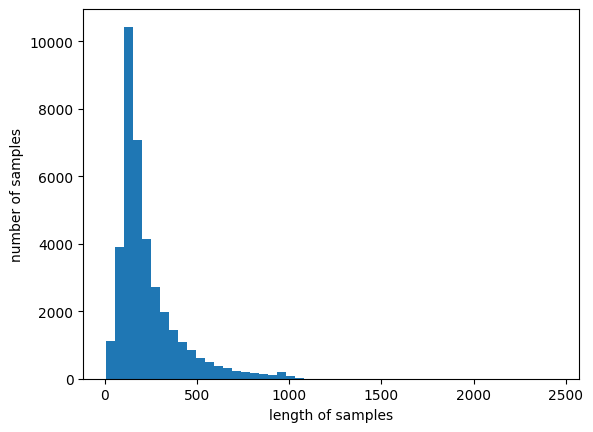

In [16]:
print('max len of reivews(num of words) :',max(len(l) for l in X_train_encode))
print('avg of reivews len :',sum(map(len, X_train_encode))/len(X_train_encode))
plt.hist([len(s) for s in X_train_encode], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('samples<=%s / total samples: %s'%(max_len, (cnt / len(nested_list))*100))

In [18]:
MAX_LEN=600
below_threshold_len(MAX_LEN, X_train_encode)
below_threshold_len(MAX_LEN, X_valid_encode)
below_threshold_len(MAX_LEN, X_test_encode)

samples<=600 / total samples: 95.43271144608688
samples<=600 / total samples: 94.75806451612904
samples<=600 / total samples: 95.66401129373803


In [19]:
X_train_encode_pad = [[0]*(MAX_LEN-len(x)) + x if len(x)<MAX_LEN\
                     else x[0:MAX_LEN] for x in X_train_encode]

X_valid_encode_pad = [[0]*(MAX_LEN-len(x)) + x if len(x)<MAX_LEN\
                     else x[0:MAX_LEN] for x in X_valid_encode]

X_test_encode_pad = [[0]*(MAX_LEN-len(x)) + x if len(x)<MAX_LEN\
                    else x[0:MAX_LEN] for x in X_test_encode]
# for i in range(len(X_train_encode)):
#     if len(X_train_encode[i]) > MAX_LEN:
#         X_train_encode[i] = X_train_encode[i][0:MAX_LEN]
#     else:
#         X_train_encode[i] = [0]*(MAX_LEN-len(X_train_encode[i])) + X_train_encode[i]

In [20]:
for x in X_train_encode_pad:
    if len(x) != 600:
        print(len(x))

## Datset, Dataloader

In [21]:
from dataset import TextDataset

In [22]:
BATCH_SIZE = 4
train_dataloader = utils.data.DataLoader(TextDataset(X_train_encode_pad, y_train), 
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         drop_last=True,
                                         num_workers=0)

test_dataloader = utils.data.DataLoader(TextDataset(X_test_encode_pad, y_test),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        drop_last=True,
                                        num_workers=0)

valid_dataloader = utils.data.DataLoader(TextDataset(X_valid_encode_pad, y_valid),
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         drop_last=True,
                                         num_workers=0)

## Model

In [23]:
class LSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, embed_dim, n_vocab, output_size, dropout_p=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.dropout = nn.Dropout(dropout_p, inplace=False)
        self.lstm = nn.LSTM(embed_dim, 
                            hidden_size, 
                            num_layers, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden, cell):
        # print('1. x : ', x.shape)
        out = self.embed(x)
        # print('2. embed : ', out.shape)
        out, (hidden, cell) = self.lstm(out, (hidden, cell))
            
        # print('3. lstm : ', out.shape)
        # print('   3-1. hiddem : ', hidden.shape)
        # print('   3-2. cell : ', cell.shape)

        self.dropout(out)
        out = out[:, -1, :]
        # print('reshape ', out.shape)
        out = self.fc(out)
        out = self.sigmoid(out)
        # print('4. fc : ', out.shape)
        return out, (hidden, cell)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return hidden, cell

In [34]:
HIDDEN_SIZE = 64
NUM_LAYERS = 1
EMBED_DIM = 128
N_VOCAB = vocab.n_words
OUTPUT_SIZE = 1
DROP_OUT_P=0.5
LR = 0.001
EPOCHS = 1
        
model = LSTM(HIDDEN_SIZE,
             NUM_LAYERS,
             EMBED_DIM,
             N_VOCAB, 
             OUTPUT_SIZE,
             DROP_OUT_P).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_bce = nn.BCELoss()

## Train, Eval function

In [40]:
def train(model, optimizer, train_dataloader):
    loss_iteration = []
    model.train()
    h, c = model.init_hidden(BATCH_SIZE)
    for batch in tqdm(train_dataloader):
        x = batch['x'].to(device)
        y = batch['y'].to(device)

        optimizer.zero_grad()
        out, _ = model(x, h, c)
        loss = loss_bce(out, y)
        loss_iteration.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    return loss_iteration

In [45]:
def evaluate(model, valid_dataloader):
    model.eval()
    corrects, total_loss, total_n_iter = 0, 0, 0
    threshold = 0.5
    loss_iteration = []
    h, c = model.init_hidden(BATCH_SIZE)
    
    for batch in tqdm(valid_dataloader):
        x = batch['x'].to(device)
        y = batch['y'].to(device)

        out, _ = model(x, h, c)        
        loss = loss_bce(out, y)        
        total_loss += loss.item()
        prediction_label = np.array(np.add(out.detach().numpy(), threshold), dtype=np.int64)
        bCorrect = (prediction_label == y.numpy()).sum()
        
        corrects += bCorrect
        total_n_iter += 1
        loss_iteration.append(loss.detach().numpy())

    avg_loss = total_loss / total_n_iter
    avg_accuracy = corrects / (total_n_iter*BATCH_SIZE)
    return avg_loss, avg_accuracy, loss_iteration

In [46]:
def plot_curve(data, x_label, y_label, title):    
    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(data)), data, '-', color='red')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

100%|██████████| 496/496 [00:03<00:00, 132.25it/s]


[Epoch: 1] val loss :  0.73 | val accuracy :  0.52


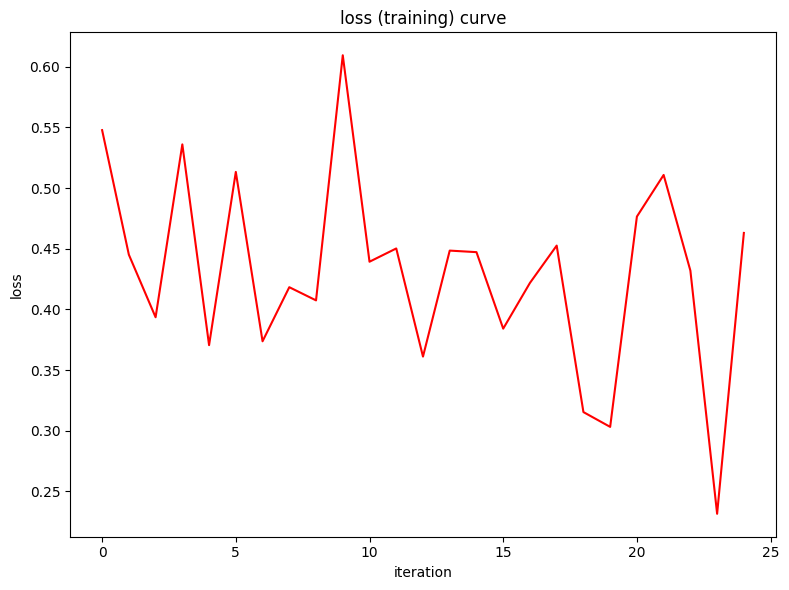

In [47]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train_loss_iteration = train(model, optimizer, train_dataloader)
    val_loss, val_accuracy, _ = evaluate(model, valid_dataloader)

    print("[Epoch: %d] val loss : %5.2f | val accuracy : %5.2f" % (e, val_loss, val_accuracy))
    plot_curve(train_loss_iteration, 'iteration', 'loss', 'loss (training) curve')

    # save least loss model
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/imdb_txt_classification.pt')
        best_val_loss = val_loss

100%|██████████| 2479/2479 [00:22<00:00, 111.51it/s]


test loss:  0.73 | test acc:  0.52


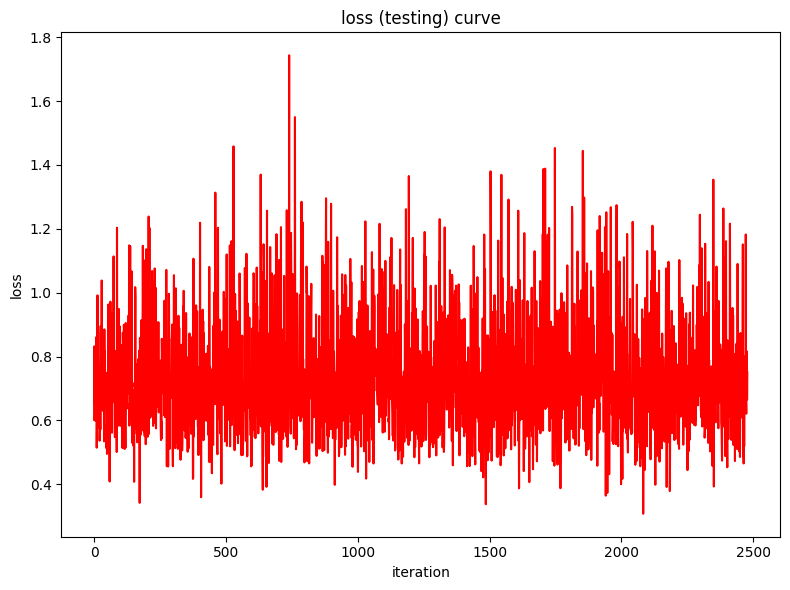

In [48]:
model.load_state_dict(torch.load('./snapshot/imdb_txt_classification.pt'))
test_loss, test_acc, loss_test_iteration = evaluate(model, test_dataloader)
print('test loss: %5.2f | test acc: %5.2f' % (test_loss, test_acc))
plot_curve(loss_test_iteration, 'iteration', 'loss', 'loss (testing) curve')
